In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus']=False  

import tensorflow as tf
from tensorflow import keras     
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import metrics

In [13]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# CNN(Convolutional Neural Network)
## 데이터 분할 및 전처리

- CIFAR-10
    - https://www.tensorflow.org/tutorials/images/cnn?hl=ko
    - 총 60,000장의 컬러 이미지
        - 훈련:(50000, 32, 32, 3) / 테스트:(10000, 32, 32, 3)
        - 정답 클래스 : 10개
- CIFAR-100 : 60,000

In [17]:
(X_train, Y_train), (X_test, Y_test)=keras.datasets.cifar10.load_data()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape  

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

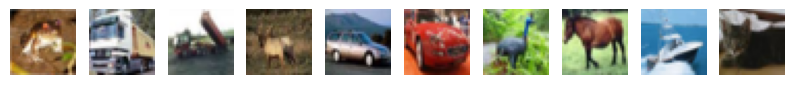

In [19]:
fig, ax=plt.subplots(1, 10, figsize=(10, 10))

for i in range(10):
    ax[i].imshow(X_train[i])
    ax[i].axis('off')
plt.show()

In [21]:
for i in range(10):
    print(Y_train[i], end=' ')

[6] [9] [9] [4] [1] [1] [2] [7] [8] [3] 

In [23]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [44]:
X_train=X_train / 255.0      # 이미지 손상때문에 reshape 0~1
X_test=X_test / 255.0
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## 모델 구성 및 학습

In [26]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(32, 32, 3)))

model.add(keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))    

model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))

model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu'))

model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,490 (798.79 KB)

 Trainable params: 204,490 (798.79 KB)

 Non-trainable params: 0 (0.00 B)

### 학습 및 평가

In [36]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
# epoch마다 진행 상황 출력
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 5 == 0:
        if 'mse' in logs:
            print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, mse={logs['mse']:.4f}", 
                  f"val_loss={logs['val_loss']:.4f}, val_mse={logs['val_loss']:.4f}")
        elif 'accuracy' in logs:   
             print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}", 
                  f"val_loss={logs['val_loss']:.4f}, val_accuracy={logs['val_accuracy']:.4f}")
            
# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='val_loss', patience=2, verbose=1,  restore_best_weights=True)

# 저장 : 모델의 성능이 향상될 때만 저장
check_pointer=keras.callbacks.ModelCheckpoint(filepath='./Deep_result/cnn_color.keras', monitor='val_loss', 
                                             verbose=1, save_best_only=True)

### CallBack 함수

In [41]:
history=model.fit(X_train, Y_train, 
                  epochs=5, batch_size=32, validation_split=0.2,
                  callbacks=[print_callback, early_stopping_callback, check_pointer])

Epoch 1/5
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3459 - loss: 2.0563
Epoch 1: val_loss improved from inf to 1.27902, saving model to ./Deep_result/cnn_color.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.3460 - loss: 2.0556 - val_accuracy: 0.5412 - val_loss: 1.2790
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5535 - loss: 1.2614
Epoch 2: val_loss improved from 1.27902 to 1.17906, saving model to ./Deep_result/cnn_color.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.5535 - loss: 1.2614 - val_accuracy: 0.5931 - val_loss: 1.1791
Epoch 3/5
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6192 - loss: 1.0826
Epoch 3: val_loss improved from 1.17906 to 1.12512, saving model to ./Deep_result/cnn_color.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6192 - loss: 1.0826 - val_accuracy: 0.6112 - val_loss: 1.1251
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6582 - loss: 0.

In [46]:
model.evaluate(X_test, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6326 - loss: 1.0771


[1.0832792520523071, 0.635200023651123]

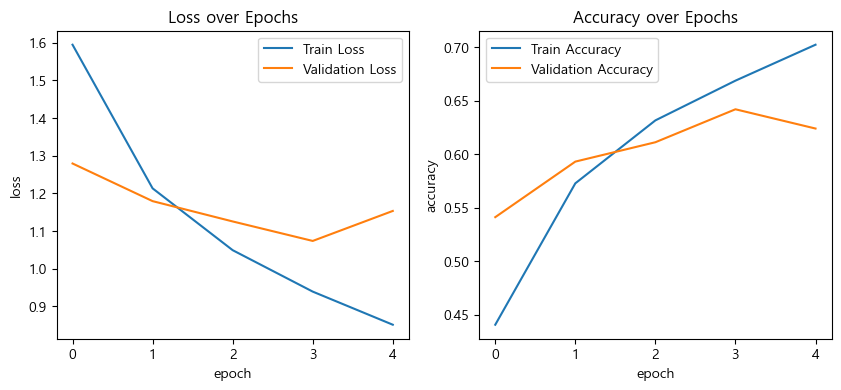

In [48]:
# 그래프 
fig, ax=plt.subplots(1, 2, figsize=(10, 4))  
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].set_title('Loss over Epochs')

ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].set_title('Accuracy over Epochs')

plt.show()

In [50]:
pred_prob=model.predict(X_test)          # 각 행의 값
pred=np.argmax(pred_prob, axis=1)        # 가장 큰 값을 가진 인덱스
pred[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


3

In [52]:
print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1000
           1       0.79      0.77      0.78      1000
           2       0.49      0.52      0.50      1000
           3       0.47      0.38      0.42      1000
           4       0.60      0.47      0.53      1000
           5       0.55      0.53      0.54      1000
           6       0.63      0.77      0.70      1000
           7       0.65      0.76      0.70      1000
           8       0.73      0.75      0.74      1000
           9       0.76      0.72      0.74      1000

    accuracy                           0.64     10000
   macro avg       0.63      0.64      0.63     10000
weighted avg       0.63      0.64      0.63     10000



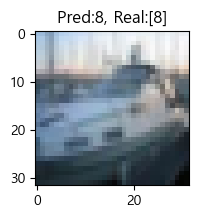

In [54]:
plt.figure(figsize=(2, 2))
plt.imshow(X_test[2])            # 그림
# plt.title(f'Label: {pred[1]}', {Y_test[1]})   # 예측 값
plt.title(f'Pred:{pred[2]}, Real:{Y_test[2]}')
plt.show()

In [67]:
# 가중치 저장 
model.save_weights('./Deep_result/cnn_color.weights.h5')

In [69]:
# 불러오기
model_cifar_load=load_model('./Deep_result/cnn_color.keras')
model_cifar_load.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 613,472 (2.34 MB)

 Trainable params: 204,490 (798.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 408,982 (1.56 MB)

In [73]:
model_cifar_load.load_weights('./Deep_result/cnn_color.weights.h5')
model_cifar_load.evaluate(X_test, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6987 - loss: 0.8834


[0.8914649486541748, 0.6960999965667725]

In [169]:
# End of file